In [175]:
import tqdm
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re 
import nltk
import os
from datetime import date, timedelta

In [176]:
pd.set_option('display.max_colwidth', 100)
pd.options.display.max_rows = 60
pd.options.display.max_colwidth = 300

ps = nltk.PorterStemmer()
stopword = nltk.corpus.stopwords.words('english')

#### Functions

In [177]:
def num_missing_rows(df):
    """
    df: DataFrame
    Return: Count of missing rows by column name
    """
    for i,v in df.iteritems():
        print('Number of nulls per {}: {}'.format(i, df[i].isnull().sum()))
    return


def shape_of_dataframe(df):
    """
    df: DataFrame
    Return: The number of rows and columns in the loaded DataFrame
    """
    return print('Input data has {} rows and {} columns'.format(len(df),len(df.columns)))


def input_tech():
    """
    input: User input with a part of or the entire technology as a string
    Return: A list of technologies the user is interested in    
    """
    tech = str(input("Enter technology: "))
    tech_list = []
    maxLengthList = 5
    while (tech != "") & (len(tech_list) < maxLengthList):
        tech_list.append(tech)
        tech = str(input("Enter technology: "))
    print(tech_list)
    return tech_list


def clean_text(text):
    """
    input: Takes a sting from a DataFrame
    Return: a list of stemmed words, excluding punctuation and stopwords and the word html from the beginnnig of the string
    """
    text = text.lstrip('html ') # use to remove 'html' from begging of string; fixed in the scraper code
    text = "".join([char for char in text if char not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopword]
    return text

### Load the data
_In case the positions are scraped in separated files concatenate the files_

In [50]:
jobs_data = pd.read_csv("it_jobs_20211710.csv")

#### Look ath the shape of the DataFrame and null values

In [150]:
shape_of_dataframe(jobs_data)
print(' ')
num_missing_rows(jobs_data)
print(' ')
print(jobs_data.info())

Input data has 6300 rows and 11 columns
 
Number of nulls per position_id: 0
Number of nulls per position_url: 0
Number of nulls per company_name: 0
Number of nulls per position_views: 0
Number of nulls per job_description: 0
Number of nulls per date_posted: 0
Number of nulls per position_rating: 2919
Number of nulls per rating_color: 2919
Number of nulls per position: 0
Number of nulls per benefits: 0
Number of nulls per technologies: 936
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6300 entries, 0 to 6299
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   position_id      6300 non-null   int64  
 1   position_url     6300 non-null   object 
 2   company_name     6300 non-null   object 
 3   position_views   6300 non-null   int64  
 4   job_description  6300 non-null   object 
 5   date_posted      6300 non-null   object 
 6   position_rating  3381 non-null   float64
 7   rating_color     3381 non-nu

## Brain Storming:
1. Technologies by companies
2. Technologies by Positions
3. Count of open positions by Company
4. Most viewed positions by companies
5. Most viewed positions 
6. Benefits from the Benefits column
7. Job posting by city

### 1. Technologies by Companies (Data cleaning + visualization)

In [159]:
# take only necessary columns
technology_company = jobs_data[['company_name', 'technologies']]
technology_company = technology_company.dropna(axis=0, how='any')

# transform the dataset
technology_company_expanded = tech_com['technologies'].str.split(',', expand=True) #split by commas
technology_company_expanded.columns = ['Technology'+str(i) for i in technology_company_expanded.columns] #set column headers
technology_company_concat = pd.concat([technology_company,technology_company_expanded], axis=1) # concatenate technology_company and technology_company_expanded
technology_company_concat.iloc[:,3:-1] = technology_company_concat.iloc[:,3:-1].apply(lambda x: x.str.strip()) #remove whitespaces from values in the columns
technology_in_company = pd.melt(technology_company_concat, id_vars=['company_name'], value_vars=technology_company_expanded.columns, var_name='Technology Number', value_name='Technology').dropna()

# groupby statement
technology_in_company = technology_in_company.groupby(['company_name', 'Technology']).count()
technology_in_company.sort_values(by=['company_name', 'Technology Number'], ascending=False, inplace=True)
technology_in_company.reset_index(inplace=True)
technology_in_company.head(15)

,company_name,Technology,Technology Number
0,флатексДЕГИРО - клон България,SQL,10
1,флатексДЕГИРО - клон България,Java,9
2,флатексДЕГИРО - клон България,Linux,9
3,флатексДЕГИРО - клон България,MySQL,7
4,флатексДЕГИРО - клон България,HTML/CSS,5
5,флатексДЕГИРО - клон България,Jenkins,5
6,флатексДЕГИРО - клон България,Jira,5
7,флатексДЕГИРО - клон България,Kafka,5
8,флатексДЕГИРО - клон България,ElasticSearch,4
9,флатексДЕГИРО - клон България,Nginx,4


In [169]:
tech_list = input_tech()

Enter technology:  python
Enter technology:  javas
Enter technology:  golang
Enter technology:  


['python', 'javas', 'golang']


In [170]:
tech_in_com_spec = pd.concat([tech_in_com[tech_in_com['Technology'].str.contains(tech, case=False, regex=False)] for tech in tech_list],ignore_index=True)
tech_in_com_spec

,company_name,Technology,Technology Number
0,флатексДЕГИРО - клон България,Python,4
1,одело България ЕООД,Python,1
2,Ърбан.ИО ЕООД,Python,1
3,Чайлдиш ООД,Python,1
4,ХОСТОПИЯ БЪЛГАРИЯ ЕООД,Python,2
...,...,...,...
752,BGStaffing EOOD,Golang,1
753,Alphatheta Music Bulgaria EOOD,Golang,1
754,Alcatraz Bulgaria EOOD,Golang,1
755,Acronis Bulgaria ЕOOD,Golang,1


In [171]:
tech_in_com_piv = tech_in_com_spec.pivot(index='company_name', columns='Technology', values='Technology Number')
tech_in_com_piv.sort_values(by='company_name', ascending=False, inplace=True)
tech_in_com_piv.reset_index(inplace=True)
tech_in_com_piv.set_index('company_name', inplace=True)
tech_in_com_piv.dropna(axis=0, how='any', inplace=True)
tech_in_com_piv

Technology,Golang,JavaScript,Python
company_name,,,
Софтуер АГ Дивелъпмънт Център България ЕООД,1.0,4.0,4.0
Самап ЕООД,1.0,1.0,1.0
СТАНГА АД,1.0,10.0,10.0
СОФТСЪРВ БЪЛГАРИЯ ЕООД,4.0,14.0,19.0
СЕКЮРАКС ЕООД,1.0,1.0,1.0
Оупънтаг ЕООД,5.0,3.0,3.0
Немечек ООД,1.0,5.0,4.0
Мобайл Уейв Солюшънс ЕООД,1.0,6.0,1.0
Меншън Технолъджи енд Опърейшънс Сентър ЕООД,1.0,1.0,3.0


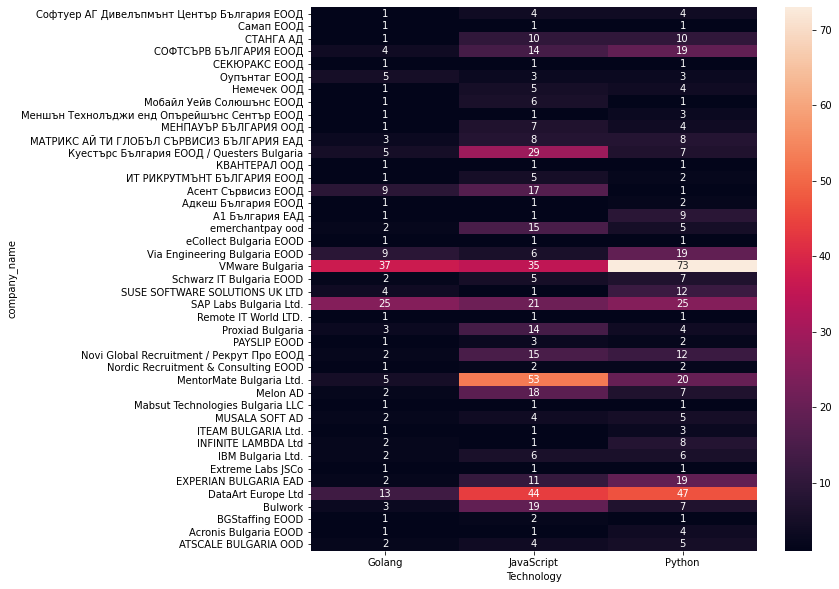

In [173]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(tech_in_com_piv, annot=True)
plt.show()

### Clean the Description field + Stem it and Vectorize it

In [174]:
descriptions = jobs_data[['position_id', 'job_description','position','company_name']]
descriptions.head()

,position_id,job_description,position,company_name
0,5944384,html Customer Support Specialist with English Are you passionate about customer service? Are you looking for an organization where your career can develop rapidly within a short time frame? Do you want to gain global experience and move into an environment of IT support learning ...,Customer Support Specialist with English,ТЕК ЕКСПЪРТС ЕООД
1,5934985,html Customer Support Specialist with English and French Are you passionate about customer service? Are you looking for an organization where your career can develop rapidly within a short time frame? Do you want to gain global experience and move into an environment of IT support ...,Customer Support Specialist with English and French,ТЕК ЕКСПЪРТС ЕООД
2,5924446,html Service Desk Administrator with English and German Do you have strong troubleshooting skills? Do you love delivering exceptional customer service? Are you looking for a rapidly growing company to take your career to the next level? Tek Experts provides business and IT outsour...,Service Desk Administrator with English and German,ТЕК ЕКСПЪРТС ЕООД
3,5950538,"html Customer Support Representative Do you love delivering great customer service? Have you worked in an environment where you support subscription sales or bill payment processes? Tek Experts provides business and IT outsourcing services, and we take intense pride in helping co...",Customer Support Representative,ТЕК ЕКСПЪРТС ЕООД
4,5933745,"html Grafixoft is a leading software engineering company with a unique spirit. Our main aim and strength is the quality of our projects and services. Our relationships are based on honest communication, respect and the firm belief that everybody operates in accordance with the shared values....",Software Engineer (C#/.NET),ГРАФИКСОФТ ООД


In [14]:
descriptions['cleaned_text'] = descriptions['job_description'].apply(lambda x: clean_text(x.lower()))

<ipython-input-14-c0de3f6ea87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  descriptions['cleaned_text'] = descriptions['job_description'].apply(lambda x: clean_text(x.lower()))


In [15]:
descriptions.sample(5)

,position_id,job_description,position,company_name,cleaned_text
2981,5864403,html What We Do We at Object Systems International (OSI) are a team of software eng...,Automation QA Engineer,Обджект Системс Интернешънъл България ЕООД,"[object, system, intern, osi, team, softwar, engin, help, client, build, world, class, product, ..."
4006,5873157,html We are looking for a C++ Developer to join the team of our customer Murka. ...,C++ Developer,МАТРИКС АЙ ТИ ГЛОБЪЛ СЪРВИСИЗ БЪЛГАРИЯ ЕАД,"[look, c, develop, join, team, custom, murka, murka, european, develop, compani, 10, year, exper..."
3894,5885597,html About us: Bulwork is the first IT recruitment agency in Bulgaria with more tha...,iOS DEVELOPER,Bulwork,"[us, bulwork, first, recruit, agenc, bulgaria, 20, year, signific, presenc, market, compani, est..."
1643,5887664,html What You'll Do The Webex Teams engineering team seeks a Software Engineer to develop an...,Middle-level Software Engineer,Cisco Systems Inc.,"[youll, webex, team, engin, team, seek, softwar, engin, develop, test, broad, rang, next, gener,..."
821,5819593,html What we do and who we are? We are the leading crypto lender that has built its reputati...,Senior Information Security Risk Analyst,Ен Ди Ес ЕООД,"[lead, crypto, lender, built, reput, blockchain, world, signatur, instant, crypto, credit, line,..."


In [16]:
from langdetect import detect

def detect_language(text):
    language = detect(text)
    return language

descriptions['detected_language'] = descriptions['job_description'].apply(lambda x: detect_language(x))
descriptions.sample(5)

descriptions_engish = descriptions[descriptions['detected_language'] == 'en']
descriptions_engish = descriptions_engish[['position_id', 'job_description', 'position', 'company_name', 'cleaned_text']]
display(descriptions_engish.info())
display(descriptions_engish.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5361 entries, 0 to 5852
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   position_id      5361 non-null   int64 
 1   job_description  5361 non-null   object
 2   position         5361 non-null   object
 3   company_name     5361 non-null   object
 4   cleaned_text     5361 non-null   object
dtypes: int64(1), object(4)
memory usage: 251.3+ KB


<ipython-input-16-19c59b4d815c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  descriptions['detected_language'] = descriptions['job_description'].apply(lambda x: detect_language(x))


None

,position_id,job_description,position,company_name,cleaned_text
0,5876034,html About the vacancy Our client is a London-based startup that provides software for onlin...,"Senior React.js Engineer, Online Events Platform",DataArt Europe Ltd,"[vacanc, client, londonbas, startup, provid, softwar, onlin, event, virtual, event, technolog, e..."
1,5877494,html Software Engineer Grafixoft has 23 years of experience in software engineering and we a...,Software Engineer,ГРАФИКСОФТ ООД,"[softwar, engin, grafixoft, 23, year, experi, softwar, engin, proud, longlast, partnership, esta..."
2,5837867,html Requisition ID: 278246 Work Area: Software-Development Operations Expected Travel: 0 - ...,Database Cloud Engineer,SAP Labs Bulgaria Ltd.,"[requisit, id, 278246, work, area, softwaredevelop, oper, expect, travel, 0, 10, career, statu, ..."
3,5877489,html Grafixoft has 23 years of experience in software engineering and we are most proud of t...,System Administrator – ProdOps Engineer,ГРАФИКСОФТ ООД,"[grafixoft, 23, year, experi, softwar, engin, proud, longlast, partnership, establish, year, par..."
4,5837874,html What we offer Our company culture is focused on helping our employees enable innovation...,Architect for Productive S4/HANA Automated Deployment into Public Cloud,SAP Labs Bulgaria Ltd.,"[offer, compani, cultur, focus, help, employe, enabl, innov, build, breakthrough, togeth, focu, ..."


#### Vectorizing: Count Vectorization

In [134]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(analyzer=clean_text)
X_counts = count_vect.fit_transform(descriptions_engish['job_description'])
print(X_counts.shape)

(5360, 17743)


In [135]:
data_sample = descriptions_engish[0:20]

count_vect_sample = CountVectorizer(analyzer=clean_text)
X_counts_sample = count_vect_sample.fit_transform(data_sample['job_description'])
print(X_counts_sample.shape)

(20, 1506)


In [136]:
X_counts_df = pd.DataFrame(X_counts_sample.toarray())
X_counts_df.columns = count_vect_sample.get_feature_names()
X_counts_df

,0,1,10,100,1000,100000,1060,16,17000,1972,...,xsd,xsl,xslt,ye,year,yearli,you,your,zone,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
2,1,0,1,0,0,0,1,0,0,1,...,0,0,0,0,1,0,3,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,3,0,0,1,0,0
4,1,0,1,0,0,1,1,0,0,0,...,0,0,0,0,2,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,0,0,0,1,0
6,1,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,4,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,1,4,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,1,0,1,0


#### Vectorizing: Count Vectorization (TF-IDF)

Creates a document-term matrix where the columns represent single unique terms (unigrams) but the cell represents a weighting meant to represent how important a word is to a document.

In [137]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(analyzer=clean_text)
X_tfidf = tfidf_vect.fit_transform(descriptions_engish['job_description'])
print(X_tfidf.shape)

(5360, 17743)


In [138]:
data_sample = descriptions_engish[0:20]

tfidf_vect_sample = TfidfVectorizer(analyzer=clean_text)
X_tfidf_sample = tfidf_vect_sample.fit_transform(data_sample['job_description'])
print(X_tfidf_sample.shape)

(20, 1506)


In [139]:
X_tfidf_df = pd.DataFrame(X_tfidf_sample.toarray())
X_tfidf_df.columns = tfidf_vect_sample.get_feature_names()
X_tfidf_df

,0,1,10,100,1000,100000,1060,16,17000,1972,...,xsd,xsl,xslt,ye,year,yearli,you,your,zone,zoom
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.041980,0.000000,0.054347,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.076712,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.020032,0.000000,0.018532,0.000000,0.000000,0.000000,0.021868,0.000000,0.000000,0.02757,...,0.000000,0.000000,0.000000,0.000000,0.010464,0.000000,0.040638,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.046084,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.089487,0.000000,0.000000,0.052831,0.000000,0.000000
4,0.024959,0.000000,0.023090,0.000000,0.000000,0.027246,0.027246,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.026074,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.092138,0.000000,0.000000,0.000000,0.071133,0.000000
6,0.029693,0.035921,0.027469,0.000000,0.000000,0.032413,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080313,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.039277,0.058881,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.025423,0.000000,0.032912,0.180108,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.039128,0.000000,0.025327,0.000000,0.045312,0.000000


In [140]:
from scipy.cluster.vq import kmeans

num_clusters = 10

cluster_centers, distortion = kmeans(X_tfidf_sample.todense(), num_clusters)
terms = tfidf_vect_sample.get_feature_names()
for i in range(num_clusters):
    center_terms = dict(zip(terms, list(cluster_centers[i])))
    sorted_terms = sorted(center_terms, key=center_terms.get, reverse=True)
    print(sorted_terms[:10])

['grafixoft', 'what', 'experi', 'offer', 'annual', 'grow', 'manag', 'engin', 'team', 'plu']
['sap', 'cloud', 'develop', 'team', 'work', 'experi', 'oper', 'technolog', 'employ', 'profession']
['project', 'manag', 'plan', 'stakehold', 'relev', 'scope', 'abl', 'initi', 'progress', 'budget']
['event', 'frontend', 'attende', 'fe', 'jqueri', 'develop', 'react', 'ui', 'lead', 'market']
['experi', 'retail', 'frontend', 'platform', 'least', 'basic', 'appoint', 'onlin', 'month', 'vacanc']
['game', 'experi', 'develop', 'abl', 'be', 'park', 'space', 'specif', 'skill', 'offic']
['insur', 'consid', 'adf', 'fadata', 'oracl', 'growth', 'would', 'objectori', 'develop', 'advantag']
['qa', 'work', 'experian', 'custom', 'inform', 'test', 'manag', 'credit', 'technic', 'balanc']
['develop', 'work', 'applic', 'code', 'experi', 'softwar', 'team', 'design', 'familiar', 'android']
['you', 'squad', 'product', 'secur', 'design', 'work', 'via', 'prioritis', 'partner', 'experi']


#### Vectorizing: TF-IDF - Dimensionality Reduction

In [233]:
tfidf = TfidfVectorizer(analyzer=clean_text)

csr_mat = tfidf.fit_transform(descriptions_engish['job_description'])
print(csr_mat.toarray())
words = tfidf.get_feature_names()
print(words)


[[0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.0294239 0.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]]
['', '0', '000', '0000', '001', '01', '010', '0100', '0100am', '0100pm', '01032021', '01042016', '01092016', '01092021', '013701705d', '019fa9926', '02', '0200', '03', '0300', '03072018', '0365', '04', '0400am', '0400pm', '04102016', '05', '05072017', '0515', '05666667', '0600', '0600pm', '062ca6bc4', '06ac398c5', '0700', '07001600h', '07092020', '07102021', '0730', '0800', '08002000', '0800h', '08092021', '08102021', '08122014', '0820', '0899', '0900', '09001800', '0900am', '09112021', '0a0b5be369', '0fef95aa58', '1', '10', '100', '1000', '10000', '100000', '1000000', '10001900', '100

#### PCA

In [350]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

csr_mat_mat = pd.DataFrame(csr_mat.toarray())

# Create a TruncatedSVD instace: svd
pca = PCA(n_components=1000)
#pca.fit(csr_mat_mat)

# Create a KMeans instance: kmeans
kmeans = KMeans(n_clusters=20)

# Create a pipeline: pipeline
pipeline = make_pipeline(pca, kmeans)

# Fit the pipeline to words
pipeline.fit(csr_mat_mat)

# Calculate the cluster labels: labels
labels = pipeline.predict(csr_mat_mat)

# Create a DataFrame aligning labels and titles: df
df = pd.DataFrame({'label': labels, 'position': list(descriptions_engish.position), 'position id': list(descriptions_engish['position_id']), 'company': list(descriptions_engish['company_name'])})

# Display df sorted by cluster label
#print(df.sort_values('label'))

In [351]:
np.sum(pca.explained_variance_ratio_)

0.8235336931869317

In [370]:
lst =[]
for i in range(1,101,5):
    km = KMeans(n_clusters=i)
    km.fit(csr_mat_mat)
    lst.append(km.inertia_)

#### TruncatedSVD

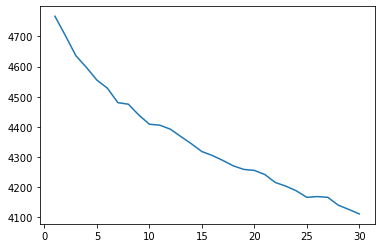

In [372]:
plt.plot(range(1,31),lst)
plt.show()

In [333]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

# Create a TruncatedSVD instace: svd
svd = TruncatedSVD(n_components=300)

# Create a KMeans instance: kmeans
kmeans = KMeans(n_clusters=20)

# Create a pipeline: pipeline
pipeline = make_pipeline(svd, kmeans)

# Fit the pipeline to words
pipeline.fit(csr_mat)

# Calculate the cluster labels: labels
labels = pipeline.predict(csr_mat)

# Create a DataFrame aligning labels and titles: df
df = pd.DataFrame({'label': labels, 'position': list(descriptions_engish.position), 'position id': list(descriptions_engish['position_id']), 'company': list(descriptions_engish['company_name'])})

# Display df sorted by cluster label
print(df.sort_values('label'))

In [336]:
svd.explained_variance_ratio_

array([0.00522373, 0.01834596, 0.01551494, 0.0106122 , 0.00971697,
       0.00908739, 0.00833544, 0.0077819 , 0.00749662, 0.00719101,
       0.00632372, 0.00593077, 0.0055282 , 0.00522877, 0.00519182,
       0.00497155, 0.00490438, 0.00482402, 0.00469419, 0.00451425,
       0.00438518, 0.00421835, 0.00415703, 0.00403604, 0.00393345,
       0.00384441, 0.00377838, 0.00368713, 0.00366862, 0.0036152 ,
       0.00356139, 0.00342807, 0.00342436, 0.00335535, 0.00331986,
       0.00330095, 0.00327764, 0.00322823, 0.00319181, 0.00311446,
       0.00306723, 0.00303906, 0.00298171, 0.00294275, 0.00285133,
       0.00282657, 0.00280709, 0.00276563, 0.00272866, 0.00270938,
       0.00268996, 0.00263809, 0.00260377, 0.00259444, 0.00255787,
       0.00251196, 0.0024719 , 0.00246641, 0.00244754, 0.00241232,
       0.00238559, 0.00237471, 0.00232635, 0.00230595, 0.00227396,
       0.00225752, 0.00223278, 0.00221031, 0.0021789 , 0.00216213,
       0.00212999, 0.00211332, 0.00208261, 0.00207983, 0.00206

In [301]:
pd.options.display.max_rows=1350

In [388]:
zero = df[df['label']==19]
zero.sort_values(by='company', ascending=False, inplace=True)
print(zero.shape)
display(zero.company.value_counts().head(10))
display(zero.head(20))

(62, 4)


<ipython-input-388-690eb601a4e0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zero.sort_values(by='company', ascending=False, inplace=True)


Novi Global Recruitment / Рекрут Про ЕООД    62
Name: company, dtype: int64

,label,position,position id,company
3694,19,Senior Survey Programmer,5888312,Novi Global Recruitment / Рекрут Про ЕООД
4229,19,System Administrator – Virtualization Technologies (Hyper-V),5893583,Novi Global Recruitment / Рекрут Про ЕООД
3917,19,Front-end Developer Team Lead,5861729,Novi Global Recruitment / Рекрут Про ЕООД
3934,19,Fiber Optics Design Engineer - REMOTE,5858745,Novi Global Recruitment / Рекрут Про ЕООД
3938,19,Fiber Optics Design Engineer - REMOTE,5858745,Novi Global Recruitment / Рекрут Про ЕООД
3939,19,Customer Support Team Lead with Turkish,5858739,Novi Global Recruitment / Рекрут Про ЕООД
3976,19,Technical Support Specialist Level 2 – FULLY REMOTE,5853950,Novi Global Recruitment / Рекрут Про ЕООД
3977,19,Technical Support Specialist with Italian and English (L1),5853949,Novi Global Recruitment / Рекрут Про ЕООД
3988,19,SAP Fiori / UI5 Developer,5853235,Novi Global Recruitment / Рекрут Про ЕООД
3989,19,Senior SAP ABAP Developer,5853203,Novi Global Recruitment / Рекрут Про ЕООД


In [389]:
pos_count_vect = CountVectorizer(analyzer=clean_text)
pos_title_count = pos_count_vect.fit_transform(zero.position)
pos_df = pd.DataFrame(pos_title_count.toarray())
pos_df.columns = pos_count_vect.get_feature_names()
pos_df.sum(axis=0).sort_values(ascending=False)

senior            21
engin             16
develop           15
remot             14
administr         11
support           10
technic            6
system             6
fulli              6
specialist         5
sap                5
it                 4
data               4
team               4
german             3
frontend           3
softwar            3
lead               3
junior             3
english            2
qa                 2
l1                 2
linux              2
optic              2
net                2
manag              2
open               2
react              2
fiber              2
sourc              2
consult            2
analyst            2
turkish            2
busi               2
cloud              2
applic             2
sql                2
design             2
typescript         1
one                1
vuej               1
oper               1
virtual            1
ui5                1
site               1
oracl              1
owner              1
payment      

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265
1500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
accept,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
analyst,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
analystautom,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
api,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
appium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
applic,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
architect,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
assur,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0
atida,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
